# Optical RL-Gym

## Training the Stable Baselines agents using the DeepRMSA environment

This file contains examples of how to train agents for the DeepRMSA environment.

The agents used in this file come from the [Stable baselines](https://github.com/hill-a/stable-baselines) framework.

This notebook is based upon the one available [here](https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/master/monitor_training.ipynb).

Before running this notebook, make sure to install Stable Baselines and the Optical RL-Gym in your Python environment.

### General imports

In [1]:
import os
import pickle
import numpy as np

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### TensorFlow imports

In [2]:
import tensorflow as tf

# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

tf.__version__

'1.15.0'

### Stable Baseline imports

In [3]:
import stable_baselines
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import results_plotter
stable_baselines.__version__

'2.10.0'

### Environment imports

In this particular example, there is no need to import anything specific to the Optical RL-Gym. Only by importing the Open AI Gym below, you already get all the functionality needed.

In [ ]:
import gym

### Define a callback function

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

### Setting up the environment

The parameters are set as in the [DeepRMSA](https://doi.org/10.1109/JLT.2019.2923615) work.

In [5]:
topology_name = 'nsfnet_chen_eon'
k_paths = 5
with open(f'../topologies/{topology_name}_{k_paths}-paths.h5', 'rb') as f:
    topology = pickle.load(f)
    
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])
env_args = dict(topology=topology, seed=10, allow_rejection=False,
               mean_service_holding_time=7.5, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)

### Creating the monitors and agent

In [6]:
# Create log dir
log_dir = "./tmp/deeprmsa-ppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

env = gym.make('DeepRMSA-v0', **env_args)

# logs will be saved in log_dir/monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking probabilities
env = Monitor(env, log_dir + 'training', info_keywords=('service_blocking_rate_since_reset','bit_rate_blocking_rate_since_reset'))

policy_args = dict(net_arch=5*[128], act_fun=tf.nn.elu) # the neural network has four layers with 150 neurons each

agent = PPO2(MlpPolicy, env, verbose=0, tensorboard_log="./tb/PPO-DeepRMSA-v0/", policy_kwargs=policy_args, gamma=.95, learning_rate=10e-5)

### Training the agent

In [7]:
agent.learn(total_timesteps=100000, callback=callback)

### Plotting the training progress

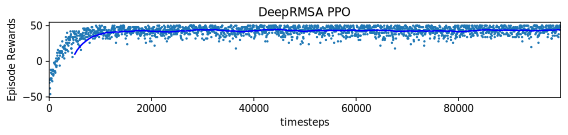

In [8]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DeepRMSA PPO")